In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

import pdb
import seaborn as sns
import matplotlib as plt
from sklearn import linear_model

In [2]:
class IncomingPredictions:
    """
    This program 
    """

    def __init__(self):
        """
        This program estimate the incoming based on the expenses in ads in social networks.
        """
        self.model = None
        self.model_path = "../models/"
        self.data_train = pd.read_csv('../data/Train.csv')
        self.data_test = pd.read_csv('../data/Test_predictors.csv')
        self.data_local_train = pd.DataFrame()
        self.data_local_test = pd.DataFrame()
        self.prediction = pd.DataFrame()
        self.best_params = dict()
        self.models_mse = dict()
        self.rdn_number = np.random.randint(200)
        
    def preprocess_data(self):
        """
        This function preprocesses the data to be used in the model. Perform a normal scaling to both, 
        train and test data set. 
        The training set is split into two different sets, based on the class distribution:
            1.- 80% of the data is just for local training.
            2.- 20% of the data is only for local testing.
            
        """
        
        # Rename the column Survived as target
        self.data_train.rename(columns={"Ingresos": "target"}, inplace=True)
        
        # Fill nan values with the mean of the column
        self.data_train.dropna(axis=0, inplace=True)

#         feature_to_drop = "Linkedin"
#         self.data_train.drop(feature_to_drop, axis=1)
#         self.data_test.drop(feature_to_drop, axis=1)

        # Drop rows with negative value in the Income
        index_to_delete = self.data_train[self.data_train.target < 0].index
        self.data_train = self.data_train.drop(index=index_to_delete, axis=0)
            
        # Scale the training data
        scale = StandardScaler()
        
        scale.fit(self.data_train.drop("target", axis=1))
        x_scaled = scale.transform(self.data_train.drop("target", axis=1))
        x_scaled = pd.DataFrame(x_scaled, columns=self.data_train.drop("target", axis=1).columns)
        self.data_train = pd.concat([x_scaled, self.data_train.target.reset_index()], axis=1)
        self.data_train = self.data_train.drop("index", axis=1)

        # Scale the test data
        scale.fit(self.data_test)
        x_test_scaled = scale.transform(self.data_test)
        self.data_test = pd.DataFrame(x_test_scaled, columns=self.data_test.columns)
        
        # Define a new training and test set
        self.data_local_train = self.data_train.sample(frac=0.8, random_state=self.rdn_number)
        self.data_local_test = self.data_train.drop(self.data_local_train.index)
        
    def train_models(self):
        """
        This function trains the model using the local training set and calculates the MSE over the local test set.
        Performs a k-fold cross validation to find the best parameters for the model.
        """
        
        # Split the data into several stratified training and test set
        kf = KFold(n_splits=6, random_state=self.rdn_number, shuffle=True)        
        
        # Create the model
        temp_model = LinearRegression()

        # Train the model
        x_train = self.data_local_train.drop("target", axis=1)
        y_train = self.data_local_train.target
        x_test = self.data_local_test.drop("target", axis=1)
        y_test = self.data_local_test.target

        prediction = None
        temp_mse = 10000000
        
        for train_index, test_index in kf.split(x_train, y_train):

            temp_model.fit(x_train.iloc[train_index], y_train.iloc[train_index])
            prediction_ = temp_model.predict(x_train.iloc[test_index])
            mse_ = metrics.mean_squared_error(y_train.iloc[test_index], prediction_)
            
            print("inner -> ", mse_)
            
            # Evaluate the model
            prediction = temp_model.predict(x_test)
            mse = metrics.mean_squared_error(y_test, prediction)
            print("Local TEST", mse, "\n")
            
            if mse < temp_mse:
                temp_mse = mse
                self.model = temp_model

        # Save the model
        with open(self.model_path + "naive_model", 'wb') as file:
            pickle.dump(self.model, file)
            
    def evaluate_model(self):
        """
        This function evaluates the model over the local test set (to calculate the final f1_score) as well as the 
        test set from the competition, which targets is unknown. Finally, save the results for competition in the file
        "y_pred" in the data folder and the model.
        """
        
        x_test = self.data_local_test.drop("target", axis=1)
        y_test = self.data_local_test.target
        
        # Evaluate the model
        y_pred = self.model.predict(x_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        
        print("Local TEST", mse)

        # Save the results
        y_pred = self.model.predict(self.data_test)
        pd.DataFrame(y_pred, columns=["target"]).to_csv('../data/y_pred.csv', index=False)
        
        return y_pred

In [3]:
ip = IncomingPredictions()

In [4]:
ip.data_train.sum()

Instagram     19792.474176
Facebook       8032.739229
Twitter       13117.205970
Linkedin      29650.971980
Discord       14067.753562
Twitch        42157.148687
Ingresos     636312.471975
dtype: float64

In [5]:
ip.preprocess_data()
ip.train_models()
y_pred = ip.evaluate_model()

inner ->  0.00010558599184057144
Local TEST 9.453927025616398e-05 

inner ->  9.968510939835105e-05
Local TEST 9.419374306058303e-05 

inner ->  9.914960077180625e-05
Local TEST 9.460131222338464e-05 

inner ->  9.812113260058235e-05
Local TEST 9.435371917747424e-05 

inner ->  9.787503327069618e-05
Local TEST 9.443820175380513e-05 

inner ->  9.88851060136493e-05
Local TEST 9.450032814931602e-05 

Local TEST 9.450032814931602e-05


## Testing with the original test set

In [6]:
test = pd.read_csv("../data/Test_target.csv", sep=",")

#### Calculate the MSE using the prediction made over the test set and the correct results  

In [7]:
metrics.mean_squared_error(pd.DataFrame(test.index).to_numpy(), y_pred)

37.06086307279407

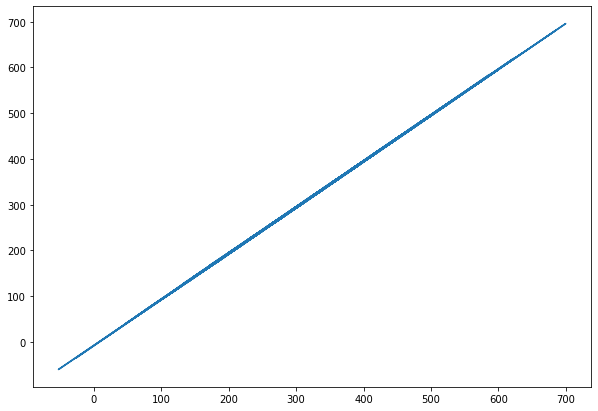

In [8]:
original_test = pd.DataFrame(test.index).to_numpy()

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 7))
plt.plot(original_test, y_pred)